In [4]:
import torch
torch.cuda.empty_cache()
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [5]:
# hyper parameters
BATCH_SIZE = 14
LEARNING_RATE = 0.0001
IMAGE_SIZE = 256

## Define UNET
https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

In [6]:
import unet

        


model = unet.UNet(1,2).to(dev)

#model(torch.rand((1, 1, IMAGE_SIZE, IMAGE_SIZE)).to(dev)).shape

## Prepare dataloaders

In [7]:
import pandas as pd

dataset = pd.read_json("./data/dataset.json")
dataset = dataset.sample(frac=1,random_state=0)[:] # shuffle
split = int(len(dataset) * 0.9)
train_df = dataset[1:split].copy()
test_df =  dataset[split:].copy()
train_df

,image_path,seg_path,set
1597,data\train\BF-C2DL-MuSC\02\t0221.tif,data\train\BF-C2DL-MuSC\02_ST\SEG\man_seg0221.tif,2
396,data\train\BF-C2DL-MuSC\01\t0396.tif,data\train\BF-C2DL-MuSC\01_ST\SEG\man_seg0396.tif,1
1583,data\train\BF-C2DL-MuSC\02\t0207.tif,data\train\BF-C2DL-MuSC\02_ST\SEG\man_seg0207.tif,2
2204,data\train\BF-C2DL-MuSC\02\t0828.tif,data\train\BF-C2DL-MuSC\02_ST\SEG\man_seg0828.tif,2
248,data\train\BF-C2DL-MuSC\01\t0248.tif,data\train\BF-C2DL-MuSC\01_ST\SEG\man_seg0248.tif,1
...,...,...,...
606,data\train\BF-C2DL-MuSC\01\t0606.tif,data\train\BF-C2DL-MuSC\01_ST\SEG\man_seg0606.tif,1
164,data\train\BF-C2DL-MuSC\01\t0164.tif,data\train\BF-C2DL-MuSC\01_ST\SEG\man_seg0164.tif,1
2154,data\train\BF-C2DL-MuSC\02\t0778.tif,data\train\BF-C2DL-MuSC\02_ST\SEG\man_seg0778.tif,2
1040,data\train\BF-C2DL-MuSC\01\t1040.tif,data\train\BF-C2DL-MuSC\01_ST\SEG\man_seg1040.tif,1


In [8]:
from torchvision.transforms import transforms, Lambda
import albumentations as A
from albumentations.pytorch import ToTensorV2
transform_train = A.Compose([

                        # augmentation 
                      #  A.ColorJitter(brightness=.1, contrast=0.15, saturation=.1, hue=.1),
        
                       # A.GaussNoise(),
                        A.Resize(IMAGE_SIZE, IMAGE_SIZE,always_apply=True),
                        A.HorizontalFlip(p=0.5),
                        A.VerticalFlip(p=0.5),
                        A.ShiftScaleRotate(rotate_limit=90,shift_limit=0.2,border_mode=0,p=0.5),

                        
                        # preprocessing
           
                        
                        ToTensorV2(),
                        ] 
                    )

transform_test = A.Compose([
                         A.Resize(IMAGE_SIZE, IMAGE_SIZE,always_apply=True),
           
                        ToTensorV2(),
                    ]   
       
                    )


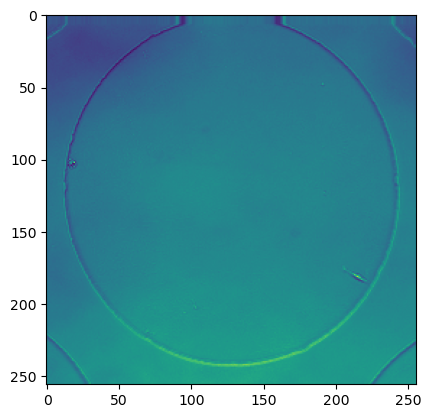

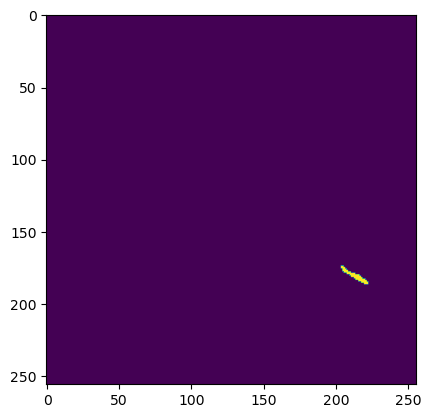

In [9]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import matplotlib.pyplot as plt
from skimage import color, io
import numpy as np
class CellSegmentationDataset(Dataset):
    def __init__(self, data, transform):
        super().__init__()
        self.data = data
        self.transform = transform
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_filepath = self.data["image_path"].iloc[idx]
        anot_filepath = self.data["seg_path"].iloc[idx]
        transformed = self.transform(image=io.imread(image_filepath).astype(np.float32),mask=io.imread(anot_filepath).astype(np.float32))
        image = transformed["image"]
        anot = transformed["mask"][None,:]>0
     
        return image, anot.long()
    
train_ds = CellSegmentationDataset(train_df, transform_train)
test_ds = CellSegmentationDataset(test_df, transform_test)
train_ds[0][0].shape, train_ds[0][1].shape
sample = train_ds[1]
plt.imshow(sample[0][0].numpy())
plt.show()
plt.imshow(sample[1][0].numpy())
plt.show()

In [10]:
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE,
                                            shuffle=True,pin_memory = True)

testloader = torch.utils.data.DataLoader(test_ds, batch_size=1,
                                        shuffle=False)

## Training

In [11]:
loss_func = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)



In [12]:
from tqdm.notebook import tqdm
from torchmetrics import JaccardIndex
def train_one_epoch(model, epoch_index, trainloader, opt, loss_func):
    running_loss = 0.
    last_loss = 0.

    model.train()
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader), leave=True, position=0):
        inputs, anot = data[0].to(dev), data[1][:,0].to(dev)
     
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, anot)
        loss.backward()
        opt.step()

        # Gather data and report
        running_loss += loss.item() / len(trainloader)

    return running_loss


def eval(model, testLoader):
   
    model.eval()
    total_loss = 0
    jc = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testLoader), total=len(testLoader), leave=True, position=0):
            inputs, anot = data[0].to(dev), data[1][:,0].to(dev)
     

            outputs = model(inputs)
            loss = loss_func(outputs, anot)
            outputs_th = outputs[0][1] > outputs[0][0]

            jaccard = JaccardIndex(num_classes=2,task="binary")
            jc += jaccard(outputs_th.to("cpu"), anot[0].to("cpu")) / len(testloader)
           # print(jc)
            total_loss += loss.item() / len(testloader)
    return total_loss, jc

In [ ]:
epochs = 200
torch.cuda.empty_cache()
for epoch in tqdm(range(0, epochs), total=epochs):
    train_loss = train_one_epoch(model, epoch, trainloader, opt, loss_func)
    valid_loss, jc = eval(model, testloader)
    print(epoch, "Training loss:", train_loss,"Valid loss:", valid_loss, "Jaccard:", jc)

torch.save(model.state_dict(), "unet.pt")

In [ ]:
torch.save(model.state_dict(), "unet.pt")

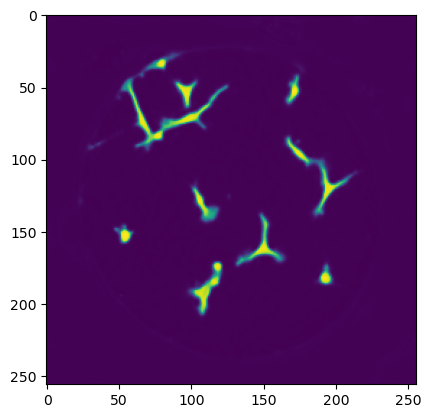

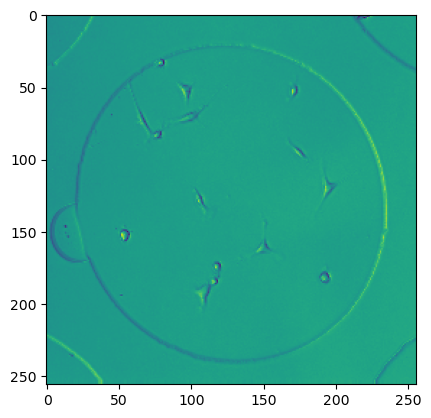

In [ ]:
a,b = test_ds[0]
res = model(a[:,None].to(dev))
res = torch.sigmoid(res)
res = res.detach().cpu().numpy()

bg, fg = res[0]   
plt.imshow(fg)
plt.show()

plt.imshow(a[0])